# Documentation technique : Système de pondération des référentiels vectoriels

## 1. Algorithme de calcul du coefficient
L'algorithme utilise un modèle dégressif pour transformer la fiabilité théorique d'une source en un poids mathématique réel pour l'arbitrage temporel :

$$Score\_Final = \max(10, \min(100, (Base - (Âge \times Malus)) + Méthode))$$

Le `COEFFICIENT_MULT` qui en résulte permet de pondérer les probabilités internes de chaque entité vectorielle.

## 2. Justification de l'échelle de valeurs

L'échelle a été calibrée selon la précision de saisie et la fiabilité thématique des vecteurs sources.

### A. Scores de base
* **95 (RPG, BD TOPO, BD FORÊT)** : Ces sources sont des vecteurs de haute précision. Leurs contours sont issus de levés photogrammétriques ou de déclarations administratives (précision infra-métrique). Ils constituent le socle de vérité terrain.
* **85 (COSIA)** : Vecteur de haute précision thématique, mais beaucoup de bruit.
* **85 (OSO)** : Bien que traité en vecteur, gros lissage des données.

### B. Paramétrage de l'ancienneté (Malus temporel)
L'analyse étant projetée en 2025, le malus assure la fraîcheur de l'information vectorielle.
* **0.50 pts/an** : Pour les zones à forte mutation. Cela garantit qu'un vecteur récent "écrase" un vecteur ancien en cas de superposition contradictoire.
* **0.25 pts/an (BD FORÊT)** : Les lisières forestières étant plus stables géométriquement, le poids du vecteur forêt est préservé plus longtemps malgré son ancienneté (2017).

### C. Correcteurs méthodologiques

L'ajustement via le paramètre `methode` reflète une méfiance technique légitime envers les processus d'automatisation par Intelligence Artificielle non supervisée ou manquant de données de validation tierces.

| Source | Valeur | Justification du Choix |
| :--- | :--- | :--- |
| **RPG_FUSION** | **+1.0** | **Validation humaine.** Source basée sur des déclarations administratives et des contrôles physiques. C'est la référence de "vérité terrain" la plus fiable du dispositif avec en complément le RPG complet. |
| **BD_TOPO** | **0** | **Neutralité topographique.** Référentiel pivot basé sur des levés précis. Sert de base de comparaison neutre. |
| **BD_FORET** | **-0.25** | **Bruit IA léger.** Utilise des processus automatisés (IA) pour la délimitation des massifs sans systématiquement croiser avec des données de terrain récentes. Le malus est faible car la thématique forestière reste stable, mais marque une réserve sur l'automatisation. |
| **COSIA** | **-1.0** | **IA dominante.** Le processus repose massivement sur des algorithmes de classification automatique.|
| **OSO** | **-1.0** | **Flux 100% IA.** Source intégralement issue d'une chaîne de traitement automatisée sur imagerie Sentinel. L'absence de supervision humaine directe sur chaque polygone justifie ce malus pour éviter que des erreurs algorithmiques ne dictent la dominance.|

## 3. Pourquoi la dominance sur vecteurs est indispensable ?

Travailler uniquement sur des vecteurs n'élimine pas les risques d'erreurs temporelles. La dominance est **matériellement obligatoire** car :

1.  **Incohérence des limites parcellaires** : Les vecteurs de sources différentes (ex: un polygone OSO et une parcelle BD TOPO) ne se superposent jamais parfaitement. Sans dominance, ces micro-écarts créeraient des milliers de polygones "résiduels" inexploitables.
2.  **Stabilité de l'étiquette** : La dominance permet d'attribuer une classe unique à la parcelle cadastrale. C'est le seul moyen de comparer 2018 et 2025 sans être pollué par les légères variations de tracés des différents millésimes.
3.  **Arbitrage expert** : En cas de conflit entre deux vecteurs, le calcul des coefficients permet de trancher pour le vecteur le plus crédible.

**Conclusion** : Ce système de pondération permet de hiérarchiser des couches vectorielles d'origines diverses. Il garantit que la dominance finale repose sur une expertise géométrique et temporelle, rendant l'analyse des trajectoires du territoire scientifiquement rigoureuse.

In [32]:
import os
import pandas as pd
from pathlib import Path

# Configuration du dossier de sortie
DIR_SORTIE = Path(r'C:/Users/liege/Desktop/GEOLAB/SORTIE/COEF_SOURCE')
os.makedirs(DIR_SORTIE, exist_ok=True)

# =============================================================
# 1. CONFIGURATION ET CALCUL DES COEFFICIENTS
# =============================================================

annee_projet = 2025

# Paramétrage expert des sources
# base : Fiabilité théorique initiale
# depreciation_annuelle : Perte de fiabilité par an (décote)
# ajustement_methode : Correction liée au mode de production (IA vs Humain)
config_sources = {
    'RPG_FUSION': {'base': 95, 'annee': 2024, 'decote_annuelle': 0.5,  'methode': 1},
    'OSO':        {'base': 85, 'annee': 2023, 'decote_annuelle': 0.5,  'methode': -1.0},
    'BD_TOPO':    {'base': 95, 'annee': 2025, 'decote_annuelle': 0.5,  'methode': 0},
    'COSIA':      {'base': 85, 'annee': 2024, 'decote_annuelle': 0.5,  'methode': -1.0},
    'BD_FORET':   {'base': 95, 'annee': 2017, 'decote_annuelle': 0.25, 'methode': -0.25}
}

lignes_calcul = []
coeffs_dict = {}

for nom, p in config_sources.items():
    # Calcul de l'ancienneté (Delta t)
    age = max(0, annee_projet - p['annee'])
    
    # Calcul de la décote cumulée
    valeur_decote = round(age * p['decote_annuelle'], 2)
    
    # Calcul du score final après ajustement méthodologique
    score_final = max(10, min(100, (p['base'] - valeur_decote) + p['methode']))
    
    # Coefficient final pour la pondération
    coeff_val = round(score_final / 100, 3)
    
    coeffs_dict[nom] = coeff_val
    
    lignes_calcul.append({
        'SOURCE': nom,
        'ANNEE_SOURCE': p['annee'],
        'AGE_CALCULE': age,
        'BASE_SOURCE': p['base'],
        'DECOTE_TEMPORELLE': valeur_decote,
        'AJUSTEMENT_METHODE': p['methode'],
        'SCORE_FINAL': score_final,
        'COEFFICIENT_PONDERE': coeff_val
    })

df_synthese = pd.DataFrame(lignes_calcul)

# Affichage des résultats
print(f"Synthèse des pondérations expertes (Référentiel {annee_projet}) :")
display(df_synthese[['SOURCE', 'AGE_CALCULE', 'DECOTE_TEMPORELLE', 'AJUSTEMENT_METHODE', 'COEFFICIENT_PONDERE']])

# =============================================================
# 2. EXPORTATION DES RÉSULTATS
# =============================================================

chemin_csv = DIR_SORTIE / "SYNTHESE_COEFFICIENTS_SOURCE.csv"

try:
    df_synthese.to_csv(chemin_csv, sep=';', index=False, encoding='utf-8')
    print(f"\nSynthèse exportée : {chemin_csv}")
except Exception as e:
    print(f"\nErreur export : {e}")  

%store coeffs_dict

Synthèse des pondérations expertes (Référentiel 2025) :


,SOURCE,AGE_CALCULE,DECOTE_TEMPORELLE,AJUSTEMENT_METHODE,COEFFICIENT_PONDERE
0,RPG_FUSION,1,0.5,1.00,0.955
1,OSO,2,1.0,-1.00,0.830
2,BD_TOPO,0,0.0,0.00,0.950
3,COSIA,1,0.5,-1.00,0.835
4,BD_FORET,8,2.0,-0.25,0.927



Synthèse exportée : C:\Users\liege\Desktop\GEOLAB\SORTIE\COEF_SOURCE\SYNTHESE_COEFFICIENTS_SOURCE.csv
Stored 'coeffs_dict' (dict)


# Consolidation multi-sources des données parcellaires

## 1. Finalité et enjeux stratégiques
Ce module constitue l'étape critique de **Data Fusion** (fusion de données) du projet. Son rôle est de transformer cinq flux de données géographiques hétérogènes (RPG, OSO, COSIA, BD TOPO et BD FORÊT) en un **référentiel unique et harmonisé** à l'échelle de la parcelle cadastrale. 

Sans cette consolidation, il serait impossible de confronter les avis des différentes sources pour arbitrer l'occupation du sol réelle de manière automatisée.

## 2. Objectifs méthodologiques
* **Pivot géographique commun** : Le module utilise un socle d'identifiants standardisés (`CODE_DEP`, `SECTION`, `NUMERO`, etc.) pour réaligner toutes les sources sur une géométrie commune : la parcelle.
* **Standardisation des schémas** : Il harmonise les noms de champs divergents pour que chaque source communique selon une structure identique (ex: suffixe `_DOM` pour la classe et `_FIAB_DOM` pour la fiabilité).
* **Normalisation des identifiants** : Un nettoyage algorithmique est appliqué pour supprimer les zéros non significatifs (ex: "0045" devient "45"), garantissant l'intégrité des jointures et évitant les pertes de données par "mismatch".
* **Intégration de la fiabilité** : Le module injecte automatiquement les coefficients de pondération (`COEFF_SOURCE`) calculés en amont selon l'ancienneté et la qualité intrinsèque de chaque source.

## 3. Logique de fusion (Jointure externe)
Pour garantir qu'aucune information ne soit perdue lors du processus, le module réalise une **jointure externe complète (Full Outer Merge)** :
* **Exhaustivité** : Si une parcelle n'est présente que dans une seule source (ex: uniquement la BD FORÊT), elle est tout de même conservée.
* **Enrichissement** : Si une parcelle est présente dans les cinq sources, ses données sont fusionnées sur une seule ligne, permettant une comparaison directe des scores.

In [33]:
import pandas as pd
import numpy as np
from pathlib import Path

# =============================================================================
# CONSOLIDATION MULTI-SOURCES DES DONNÉES PARCELLAIRES
# =============================================================================
"""
Ce module assure la fusion des indicateurs de classification issus des cinq sources
de données (RPG, OSO, COSIA, BD TOPO, BD FORÊT). 
Il harmonise la nomenclature des champs, normalise les identifiants parcellaires
et intègre les coefficients de fiabilité calculés par l'expertise métier.
"""

# 1. PARAMÉTRAGE DE L'ENVIRONNEMENT ET DES RÉFÉRENTIELS
# --------------------------------------------------------
# Définition du répertoire racine pour la récupération des flux de données
DIR_SORTIE_ROOT = Path(r'C:/Users/liege/Desktop/GEOLAB/SORTIE')

# Définition du socle d'identification géographique pour les jointures
CHAMPS_ID_SOCLE = ["CODE_DEP", "NOM_COM", "CODE_COM", "SECTION", "NUMERO", "DALLE"]

# Cartographie des fichiers sources et de leurs emplacements respectifs
CHEMINS_SOURCES = {
    'RPG_FUSION': DIR_SORTIE_ROOT / "SYNTHESE_RPG_FREQUENCE.csv",
    'OSO':        DIR_SORTIE_ROOT / "SYNTHESE_OSO_FREQUENCE.csv",
    'COSIA':      DIR_SORTIE_ROOT / "SYNTHESE_COSIA_FREQUENCE.csv",
    'BD_TOPO':    DIR_SORTIE_ROOT / "CSV_BDTOPO" / "STAT_PARCELLES_BDTOPO_2025.csv",
    'BD_FORET':   DIR_SORTIE_ROOT / "CSV_FORET" / "STAT_PARCELLES_FORET_2017.csv"
}

# 2. LOGIQUE DE PRÉPARATION ET DE NORMALISATION DES DONNÉES
# ---------------------------------------------------------
def preparer_donnees_source(nom_src, chemin, col_dom, col_fiab, col_stab=None):
    """
    Assure l'ingestion, le nettoyage des identifiants et la standardisation 
    du schéma de données pour une source spécifique.
    """
    if not chemin.exists():
        print(f"      ! Information : Flux {nom_src} non détecté à l'emplacement prévu.")
        return None

    # Chargement avec typage strict des identifiants en chaînes de caractères
    df = pd.read_csv(chemin, sep=';', dtype={c: str for c in CHAMPS_ID_SOCLE + ['PL']})
    
    # Normalisation des identifiants : suppression des zéros non significatifs
    for col in ['CODE_COM', 'NUMERO']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lstrip('0').replace('', '0')
    
    # Définition du dictionnaire de renommage standardisé
    mapping_colonnes = {
        col_dom: f"{nom_src}_DOM",
        col_fiab: f"{nom_src}_FIAB_DOM"
    }
    
    selection_cols = ['PL'] + CHAMPS_ID_SOCLE + [col_dom, col_fiab]
    
    # Intégration conditionnelle de l'indicateur de stabilité temporelle
    if col_stab and col_stab in df.columns:
        mapping_colonnes[col_stab] = f"{nom_src}_STAB"
        selection_cols.append(col_stab)
    
    # Création du DataFrame formaté et application du renommage
    df_formate = df[selection_cols].copy().rename(columns=mapping_colonnes)
    
    # Injection du coefficient de fiabilité de la source (issu de coeffs_dict)
    try:
        valeur_coeff = coeffs_dict.get(nom_src, 0.0)
    except NameError:
        valeur_coeff = 0.0
        
    df_formate[f"{nom_src}_COEFF_SOURCE"] = valeur_coeff
    
    # Initialisation de la colonne stabilité à NaN pour les sources sans historique
    if f"{nom_src}_STAB" not in df_formate.columns:
        df_formate[f"{nom_src}_STAB"] = np.nan
        
    return df_formate

# 3. EXÉCUTION DE LA SYNTHÈSE (JOINTURES SYSTÉMATIQUES)
# -----------------------------------------------------
df_synthese_globale = None

# Configuration des métadonnées sources pour le traitement automatisé
config_colonnes = {
    'RPG_FUSION': ('DOMINANTE', 'PROBA_PONDEREE', 'SCORE_STABILITE'),
    'OSO':        ('DOM_OSO_FINALE', 'PROBA_MOY_ELU', 'SCORE_STABILITE'),
    'COSIA':      ('COSIA_CLASSE_FINALE', 'PROBA_MOYENNE', 'SCORE_STABILITE'),
    'BD_TOPO':    ('DOMINANTE', 'PROBA_DOMINANTE', None),
    'BD_FORET':   ('DOMINANTE', 'PROBA_DOMINANTE', None)
}

print("Fusion des référentiels multi-sources en cours...")

for source, params in config_colonnes.items():
    df_temp = preparer_donnees_source(source, CHEMINS_SOURCES[source], *params)
    
    if df_temp is not None:
        if df_synthese_globale is None:
            df_synthese_globale = df_temp
        else:
            # Jointure externe (outer merge) pour assurer l'exhaustivité des parcelles
            df_synthese_globale = pd.merge(
                df_synthese_globale, 
                df_temp, 
                on=['PL'] + CHAMPS_ID_SOCLE, 
                how='outer'
            )

# 4. FINALISATION ET RESTITUTION DES DONNÉES CONSOLIDÉES
# ------------------------------------------------------
if df_synthese_globale is not None:
    # Réorganisation structurelle des colonnes : Identifiants puis Variables Métiers
    cols_id = ['PL'] + CHAMPS_ID_SOCLE
    cols_data = sorted([c for c in df_synthese_globale.columns if c not in cols_id])
    df_synthese_globale = df_synthese_globale[cols_id + cols_data]

    # Paramétrage de Pandas pour une visualisation exhaustive des colonnes
    pd.set_option('display.max_columns', None)

    print(f"Synthèse terminée : {len(df_synthese_globale)} unités foncières consolidées.")
    
    # Affichage du résultat final pour contrôle qualité
    display(df_synthese_globale.head(10))
else:
    print("Erreur critique : Aucun flux de données n'a pu être fusionné.")

Fusion des référentiels multi-sources en cours...
Synthèse terminée : 6792 unités foncières consolidées.


,PL,CODE_DEP,NOM_COM,CODE_COM,SECTION,NUMERO,DALLE,BD_FORET_COEFF_SOURCE,BD_FORET_DOM,BD_FORET_FIAB_DOM,BD_FORET_STAB,BD_TOPO_COEFF_SOURCE,BD_TOPO_DOM,BD_TOPO_FIAB_DOM,BD_TOPO_STAB,COSIA_COEFF_SOURCE,COSIA_DOM,COSIA_FIAB_DOM,COSIA_STAB,OSO_COEFF_SOURCE,OSO_DOM,OSO_FIAB_DOM,OSO_STAB,RPG_FUSION_COEFF_SOURCE,RPG_FUSION_DOM,RPG_FUSION_FIAB_DOM,RPG_FUSION_STAB
0,110040A0065,11,Alaigne,4,0A,65,3,0.927,AUTRE,0,NaN,0.95,AUTRE,0,NaN,0.835,AGRICULTURE,85.400,100.0,0.83,AGRICULTURE,66.0,100.0,0.955,AGRICULTURE,100.0,100.0
1,110040A0170,11,Alaigne,4,0A,170,3,0.927,BOIS,100,NaN,0.95,AUTRE,0,NaN,0.835,BOIS,85.426,100.0,0.83,BOIS,80.0,100.0,0.955,AUTRE,0.0,100.0
2,110040A0171,11,Alaigne,4,0A,171,3,0.927,BOIS,100,NaN,0.95,AUTRE,0,NaN,0.835,BOIS,86.600,100.0,0.83,BOIS,86.2,83.3,0.955,AUTRE,0.0,100.0
3,110040A0172,11,Alaigne,4,0A,172,3,0.927,BOIS,100,NaN,0.95,AUTRE,0,NaN,0.835,BOIS,86.600,100.0,0.83,BOIS,80.8,100.0,0.955,AUTRE,0.0,100.0
4,110040A0173,11,Alaigne,4,0A,173,3,0.927,BOIS,100,NaN,0.95,AUTRE,0,NaN,0.835,BOIS,86.160,100.0,0.83,BOIS,82.0,100.0,0.955,AUTRE,0.0,100.0
5,110040A0174,11,Alaigne,4,0A,174,3,0.927,BOIS,100,NaN,0.95,AUTRE,0,NaN,0.835,BOIS,86.600,100.0,0.83,BOIS,80.9,100.0,0.955,AUTRE,0.0,100.0
6,110040A0175,11,Alaigne,4,0A,175,3,0.927,AUTRE,0,NaN,0.95,AUTRE,0,NaN,0.835,AGRICULTURE,81.735,100.0,0.83,ARTIFICIALISE,46.8,66.7,0.955,AGRICULTURE,100.0,100.0
7,110040A0176,11,Alaigne,4,0A,176,3,0.927,BOIS,100,NaN,0.95,AUTRE,0,NaN,0.835,BOIS,86.600,100.0,0.83,BOIS,81.1,100.0,0.955,AUTRE,0.0,100.0
8,110040A0177,11,Alaigne,4,0A,177,3,0.927,BOIS,100,NaN,0.95,AUTRE,0,NaN,0.835,BOIS,86.600,100.0,0.83,BOIS,89.0,50.0,0.955,AUTRE,0.0,100.0
9,110040A0178,11,Alaigne,4,0A,178,3,0.927,AUTRE,0,NaN,0.95,AUTRE,0,NaN,0.835,AGRICULTURE,93.288,100.0,0.83,ARTIFICIALISE,48.2,83.3,0.955,AGRICULTURE,100.0,100.0


# Rapport méthodologique : Architecture de fusion et d'arbitrage multi-sources

## 1. Logique mathématique de l'arbitrage

L'arbitrage repose sur un calcul de score pondéré par classe thématique. Pour chaque parcelle, le système calcule cinq scores (ARTIFICIALISE, AGRICULTURE, NATURE, BOIS, EAU).

### A. Équation du Score Thématique
Pour chaque classe $cl$ et chaque parcelle, le score est défini par la somme des contributions des sources $src$ soutenant cette classe :

$$Score_{cl} = \sum_{src} \left( F_{src} \times C_{src} \times \left( 1 + \frac{S_{src}}{1000} \right) \times B_{src,cl} \right)$$

**Variables de l'équation :**
* $F_{src}$ (**Fiabilité**) : Probabilité ou confiance interne.
* $C_{src}$ (**Coefficient Source**) : Poids lié à la qualité intrinsèque du référentiel (âge de la donnée, méthode de saisie).
* $S_{src}$ (**Stabilité**) : Bonus lié à la persistance historique de l'état (Score de stabilité).
* $B_{src,cl}$ (**Bonus Expertise**) : Multiplicateur issu de la matrice de compétences.

### B. Matrice de Pondération des Compétences
Le système hiérarchise les sources selon leur légitimité thématique via trois niveaux de bonus :
* **Bonus Expert (1.5)** : Cœur de métier de la source (ex: AGRICULTURE pour le RPG).
* **Bonus Secondaire (1.2)** : Compétence croisée reconnue (ex: NATURE pour la BD FORÊT).
* **Bonus Léger (1.1)** : Signal faible ou présence marginale identifiée.

## 2. Indicateurs de Robustesse et Qualité

Trois indicateurs clés permettent de qualifier la décision finale :

### A. Nombre de Sources Compétentes (`NB_SOURCES_COMPETENTES`)
Il comptabilise le nombre de référentiels ayant fourni une donnée exploitable (différente de "AUTRE" ou vide) sur la parcelle. Cet indicateur mesure la richesse de l'information disponible pour l'arbitrage.

### B. Nombre de Sources en Accord (`NB_SOURCES_ACCORD`)
Il mesure le consensus en dénombrant les sources dont la prédiction originale correspond à la `CLASSE_FINALE` retenue par l'algorithme.

### C. Marge de Victoire (`MARGE_VICTOIRE`)
La marge représente l'écart entre le score de la classe lauréate et celui de la classe concurrente immédiate :
$$Marge = Score_{rang 1} - Score_{rang 2}$$
Une marge élevée est synonyme d'une décision tranchée, tandis qu'une marge faible signale un conflit entre experts.

## 3. Organisation de la Structure de Sortie

Le tableau final est organisé de manière à garantir une traçabilité totale du processus de décision :

| Bloc | Contenu |
| :--- | :--- |
| **Identifiants** | Pivot géographique (`PL`, `CODE_COM`, `SECTION`, etc.) |
| **Données sources** | Dominances brutes, fiabilités et stabilités initiales de chaque source |
| **Diagnostic** | Métriques de robustesse (`ACCORD`, `COMPETENCE`, `MARGE`) |
| **Décision** | `CLASSE_FINALE` et `INDICE_CONFIANCE_FINAL` |
| **Scores** | Détail mathématique des points obtenus par chaque thématique |

In [39]:
import pandas as pd
import numpy as np
from pathlib import Path

# =============================================================================
# SYNTHÈSE TOTALE ET ARBITRAGE DÉCISIONNEL
# =============================================================================

# 1. PARAMÉTRAGE DES FLUX ET RÉFÉRENTIELS
# --------------------------------------------------------
DIR_SORTIE_ROOT = Path(r'C:/Users/liege/Desktop/GEOLAB/SORTIE')
CHAMPS_ID_SOCLE = ["CODE_DEP", "NOM_COM", "CODE_COM", "SECTION", "NUMERO", "DALLE"]

CHEMINS_SOURCES = {
    'RPG_FUSION': DIR_SORTIE_ROOT / "SYNTHESE_RPG_FREQUENCE.csv",
    'OSO':        DIR_SORTIE_ROOT / "SYNTHESE_OSO_FREQUENCE.csv",
    'COSIA':      DIR_SORTIE_ROOT / "SYNTHESE_COSIA_FREQUENCE.csv",
    'BD_TOPO':    DIR_SORTIE_ROOT / "CSV_BDTOPO" / "STAT_PARCELLES_BDTOPO_2025.csv",
    'BD_FORET':   DIR_SORTIE_ROOT / "CSV_FORET" / "STAT_PARCELLES_FORET_2017.csv"
}

# Configuration des noms de colonnes pour l'importation
config_colonnes = {
    'RPG_FUSION': ('DOMINANTE', 'PROBA_PONDEREE', 'SCORE_STABILITE'),
    'OSO':        ('DOM_OSO_FINALE', 'PROBA_MOY_ELU', 'SCORE_STABILITE'),
    'COSIA':      ('COSIA_CLASSE_FINALE', 'PROBA_MOYENNE', 'SCORE_STABILITE'),
    'BD_TOPO':    ('DOMINANTE', 'PROBA_DOMINANTE', None),
    'BD_FORET':   ('DOMINANTE', 'PROBA_DOMINANTE', None)
}

# 2. PHASE DE CONSOLIDATION
# ---------------------------------------------------------
def preparer_donnees_source(nom_src, chemin, col_dom, col_fiab, col_stab=None):
    if not chemin.exists():
        return None
    df = pd.read_csv(chemin, sep=';', dtype={c: str for c in CHAMPS_ID_SOCLE + ['PL']})
    for col in ['CODE_COM', 'NUMERO']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lstrip('0').replace('', '0')
    mapping = {col_dom: f"{nom_src}_DOM", col_fiab: f"{nom_src}_FIAB_DOM"}
    selection = ['PL'] + CHAMPS_ID_SOCLE + [col_dom, col_fiab]
    if col_stab and col_stab in df.columns:
        mapping[col_stab] = f"{nom_src}_STAB"
        selection.append(col_stab)
    df_formate = df[selection].copy().rename(columns=mapping)
    df_formate[f"{nom_src}_COEFF_SOURCE"] = coeffs_dict.get(nom_src, 0.0)
    if f"{nom_src}_STAB" not in df_formate.columns:
        df_formate[f"{nom_src}_STAB"] = np.nan
    return df_formate

df_synthese_globale = None
for source, params in config_colonnes.items():
    df_temp = preparer_donnees_source(source, CHEMINS_SOURCES[source], *params)
    if df_temp is not None:
        if df_synthese_globale is None:
            df_synthese_globale = df_temp
        else:
            df_synthese_globale = pd.merge(df_synthese_globale, df_temp, on=['PL'] + CHAMPS_ID_SOCLE, how='outer')

# 3. PHASE D'ARBITRAGE
# ---------------------------------------------------------
B_EXPERT, B_SECOND, B_LEGER = 1.5, 1.2, 1.1
domaines_experts = {
    'RPG_FUSION': {'AGRICULTURE': B_EXPERT, 'NATURE': B_SECOND, 'ARTIFICIALISE': B_LEGER},
    'BD_TOPO':    {'ARTIFICIALISE': B_EXPERT, 'EAU': B_EXPERT, 'NATURE': B_SECOND},
    'BD_FORET':   {'BOIS': B_EXPERT, 'NATURE': B_SECOND}
}
classes_finales = ["ARTIFICIALISE", "AGRICULTURE", "NATURE", "BOIS", "EAU"]
sources_noms = ['RPG_FUSION', 'OSO', 'COSIA', 'BD_TOPO', 'BD_FORET']
colonnes_scores = [f"SCORE_{cl}" for cl in classes_finales]

for cl in classes_finales:
    score_col = f"SCORE_{cl}"
    df_synthese_globale[score_col] = 0.0
    for src in sources_noms:
        if f"{src}_DOM" in df_synthese_globale.columns:
            f_stab = 1 + (df_synthese_globale[f"{src}_STAB"].fillna(0) / 1000)
            base_pts = (df_synthese_globale[f"{src}_FIAB_DOM"] * df_synthese_globale[f"{src}_COEFF_SOURCE"] * f_stab)
            bonus = domaines_experts.get(src, {}).get(cl, 1.0)
            mask = (df_synthese_globale[f"{src}_DOM"] == cl)
            df_synthese_globale.loc[mask, score_col] += (base_pts[mask] * bonus)

# Détermination de la classe finale et marges
df_synthese_globale['CLASSE_FINALE'] = df_synthese_globale[colonnes_scores].idxmax(axis=1).str.replace('SCORE_', '')
all_scores = df_synthese_globale[colonnes_scores].values
all_scores.sort(axis=1)
df_synthese_globale['MARGE_VICTOIRE'] = np.round(all_scores[:, -1] - all_scores[:, -2], 2)

# 4. MÉTRIQUES ET RÉORGANISATION FINALE
# ---------------------------------------------------------
def evaluer_robustesse(row):
    elu = row['CLASSE_FINALE']
    sources_en_accord = []
    nb_competents = 0
    for src in sources_noms:
        dom = row.get(f"{src}_DOM")
        if pd.notna(dom) and dom in classes_finales:
            nb_competents += 1
            if dom == elu:
                sources_en_accord.append(row[f"{src}_FIAB_DOM"] * row[f"{src}_COEFF_SOURCE"])
    nb_accord = len(sources_en_accord)
    confiance = np.mean(sources_en_accord) if sources_en_accord else 0.0
    return nb_accord, nb_competents, round(confiance, 2)

res_metriques = df_synthese_globale.apply(evaluer_robustesse, axis=1)
df_metriques = pd.DataFrame(res_metriques.tolist(), index=df_synthese_globale.index, 
                            columns=['NB_SOURCES_ACCORD', 'NB_SOURCES_COMPETENTES', 'INDICE_CONFIANCE_FINAL'])

df_synthese_globale = pd.concat([df_synthese_globale, df_metriques], axis=1)

# Organisation finale des colonnes : IDs | Données Sources | Métriques | CLASSE_FINALE | SCORES
cols_id = ['PL'] + CHAMPS_ID_SOCLE
cols_metriques = ['NB_SOURCES_COMPETENTES', 'NB_SOURCES_ACCORD', 'MARGE_VICTOIRE']
cols_decision = ['CLASSE_FINALE', 'INDICE_CONFIANCE_FINAL']
cols_sources = [c for c in df_synthese_globale.columns if c not in cols_id + cols_metriques + cols_decision + colonnes_scores]

# Correction SettingWithCopyWarning : ajout de .copy()
df_final = df_synthese_globale[cols_id + cols_sources + cols_metriques + ['CLASSE_FINALE'] + colonnes_scores + ['INDICE_CONFIANCE_FINAL']].copy()

# --- EXPORTATION DE LA TABLE PRINCIPALE UNIQUEMENT ---
df_final.to_csv(DIR_SORTIE_ROOT / "SYNTHESE_FINALE_ARBITRAGE.csv", sep=';', index=False, encoding='utf-8')

pd.set_option('display.max_columns', None)
display(df_final.head(10))

,PL,CODE_DEP,NOM_COM,CODE_COM,SECTION,NUMERO,DALLE,RPG_FUSION_DOM,RPG_FUSION_FIAB_DOM,RPG_FUSION_STAB,RPG_FUSION_COEFF_SOURCE,OSO_DOM,OSO_FIAB_DOM,OSO_STAB,OSO_COEFF_SOURCE,COSIA_DOM,COSIA_FIAB_DOM,COSIA_STAB,COSIA_COEFF_SOURCE,BD_TOPO_DOM,BD_TOPO_FIAB_DOM,BD_TOPO_COEFF_SOURCE,BD_TOPO_STAB,BD_FORET_DOM,BD_FORET_FIAB_DOM,BD_FORET_COEFF_SOURCE,BD_FORET_STAB,NB_SOURCES_COMPETENTES,NB_SOURCES_ACCORD,MARGE_VICTOIRE,CLASSE_FINALE,SCORE_ARTIFICIALISE,SCORE_AGRICULTURE,SCORE_NATURE,SCORE_BOIS,SCORE_EAU,INDICE_CONFIANCE_FINAL
0,110040A0065,11,Alaigne,4,0A,65,3,AGRICULTURE,100.0,100.0,0.955,AGRICULTURE,66.0,100.0,0.83,AGRICULTURE,85.400,100.0,0.835,AUTRE,0,0.95,NaN,AUTRE,0,0.927,NaN,3,3,296.27,AGRICULTURE,0.000000,296.272900,0.0,0.000000,0.0,73.86
1,110040A0170,11,Alaigne,4,0A,170,3,AUTRE,0.0,100.0,0.955,BOIS,80.0,100.0,0.83,BOIS,85.426,100.0,0.835,AUTRE,0,0.95,NaN,BOIS,100,0.927,NaN,3,3,290.55,BOIS,0.000000,0.000000,0.0,290.553781,0.0,76.81
2,110040A0171,11,Alaigne,4,0A,171,3,AUTRE,0.0,100.0,0.955,BOIS,86.2,83.3,0.83,BOIS,86.600,100.0,0.835,AUTRE,0,0.95,NaN,BOIS,100,0.927,NaN,3,3,296.10,BOIS,0.000000,0.000000,0.0,296.097882,0.0,78.85
3,110040A0172,11,Alaigne,4,0A,172,3,AUTRE,0.0,100.0,0.955,BOIS,80.8,100.0,0.83,BOIS,86.600,100.0,0.835,AUTRE,0,0.95,NaN,BOIS,100,0.927,NaN,3,3,292.36,BOIS,0.000000,0.000000,0.0,292.362500,0.0,77.36
4,110040A0173,11,Alaigne,4,0A,173,3,AUTRE,0.0,100.0,0.955,BOIS,82.0,100.0,0.83,BOIS,86.160,100.0,0.835,AUTRE,0,0.95,NaN,BOIS,100,0.927,NaN,3,3,293.05,BOIS,0.000000,0.000000,0.0,293.053960,0.0,77.57
5,110040A0174,11,Alaigne,4,0A,174,3,AUTRE,0.0,100.0,0.955,BOIS,80.9,100.0,0.83,BOIS,86.600,100.0,0.835,AUTRE,0,0.95,NaN,BOIS,100,0.927,NaN,3,3,292.45,BOIS,0.000000,0.000000,0.0,292.453800,0.0,77.39
6,110040A0175,11,Alaigne,4,0A,175,3,AGRICULTURE,100.0,100.0,0.955,ARTIFICIALISE,46.8,66.7,0.83,AGRICULTURE,81.735,100.0,0.835,AUTRE,0,0.95,NaN,AUTRE,0,0.927,NaN,3,2,191.21,AGRICULTURE,41.434895,232.648598,0.0,0.000000,0.0,81.87
7,110040A0176,11,Alaigne,4,0A,176,3,AUTRE,0.0,100.0,0.955,BOIS,81.1,100.0,0.83,BOIS,86.600,100.0,0.835,AUTRE,0,0.95,NaN,BOIS,100,0.927,NaN,3,3,292.64,BOIS,0.000000,0.000000,0.0,292.636400,0.0,77.44
8,110040A0177,11,Alaigne,4,0A,177,3,AUTRE,0.0,100.0,0.955,BOIS,89.0,50.0,0.83,BOIS,86.600,100.0,0.835,AUTRE,0,0.95,NaN,BOIS,100,0.927,NaN,3,3,296.16,BOIS,0.000000,0.000000,0.0,296.155600,0.0,79.63
9,110040A0178,11,Alaigne,4,0A,178,3,AGRICULTURE,100.0,100.0,0.955,ARTIFICIALISE,48.2,83.3,0.83,AGRICULTURE,93.288,100.0,0.835,AUTRE,0,0.95,NaN,AUTRE,0,0.927,NaN,3,2,199.92,AGRICULTURE,43.338500,243.260028,0.0,0.000000,0.0,86.70


# Documentation technique : Dashboard de qualification de l'arbitrage

## 1. Architecture de la figure (`GridSpec`)

L'utilisation de `matplotlib.gridspec.GridSpec(2, 3)` est un choix structurel permettant une lecture hiérarchique des données :
* **La ligne supérieure** est dédiée aux indicateurs de **processus** (comment les sources interagissent).
* **La ligne inférieure** est dédiée aux indicateurs de **résultats** (quelle est la qualité finale par thématique).

## 2. Justification des choix de visualisation

### A. Analyse de distribution (`sns.boxplot`)
**Code :** `sns.boxplot(x='NB_SOURCES_ACCORD', y='INDICE_CONFIANCE_FINAL')`
* **Objectif :** Valider la stabilité de l'indice de confiance.
* **Justification :** Le boxplot est l'outil optimal pour visualiser la dispersion. Une réduction de la taille des "moustaches" à mesure que l'accord augmente prouve statistiquement que la convergence des sources verrouille la fiabilité de la donnée.

### B. Estimation de densité de noyau (`sns.kdeplot`)
**Code :** `sns.kdeplot(x='MARGE_VICTOIRE', hue='CLASSE_FINALE', fill=True)`
* **Objectif :** Mesurer la puissance de discrimination du modèle.
* **Justification :** Contrairement à un histogramme classique, le KDE lisse les variations pour identifier les "pics de certitude". Si une courbe est décalée vers la droite, cela justifie que le système de bonus expert a fonctionné en créant un écart de score significatif.

### C. Matrice de corrélation thermique (`sns.heatmap`)
**Code :** `df.pivot_table(...)` puis `sns.heatmap(annot=True, fmt='d')`
* **Objectif :** Identifier les zones de stress du modèle.
* **Justification :** La heatmap permet une lecture immédiate du volume de données (fréquences absolues). Elle met en lumière le ratio entre "Sources disponibles" et "Sources d'accord", isolant ainsi les parcelles litigieuses.

### D. Analyse de performance thématique (`sns.barplot`)
**Code :** `sns.barplot(x='INDICE_CONFIANCE_FINAL', y='CLASSE_FINALE', errorbar="sd")`
* **Objectif :** Comparer la fiabilité des classes d'occupation du sol.
* **Justification :** L'ajout de l'écart-type (`errorbar="sd"`) est crucial. Il permet de justifier que certaines classes (ex: Eau) sont non seulement précises, mais constantes, contrairement à d'autres (ex: Nature) qui peuvent être plus volatiles.

### E. Synthèse qualitaire (`ax.pie` avec `wedgeprops`)
**Code :** `pd.cut(...)` puis `ax5.pie(width=0.4)`
* **Objectif :** Produire l'indicateur clsé de performance (KPI) final.
* **Justification :** Le choix d'un graphique en anneau (Donut Chart) permet de focaliser l'attention sur les proportions relatives des trois zones de confiance : **Incertain** (0-50), **Acceptable** (50-75) et **Robuste** (75-100).

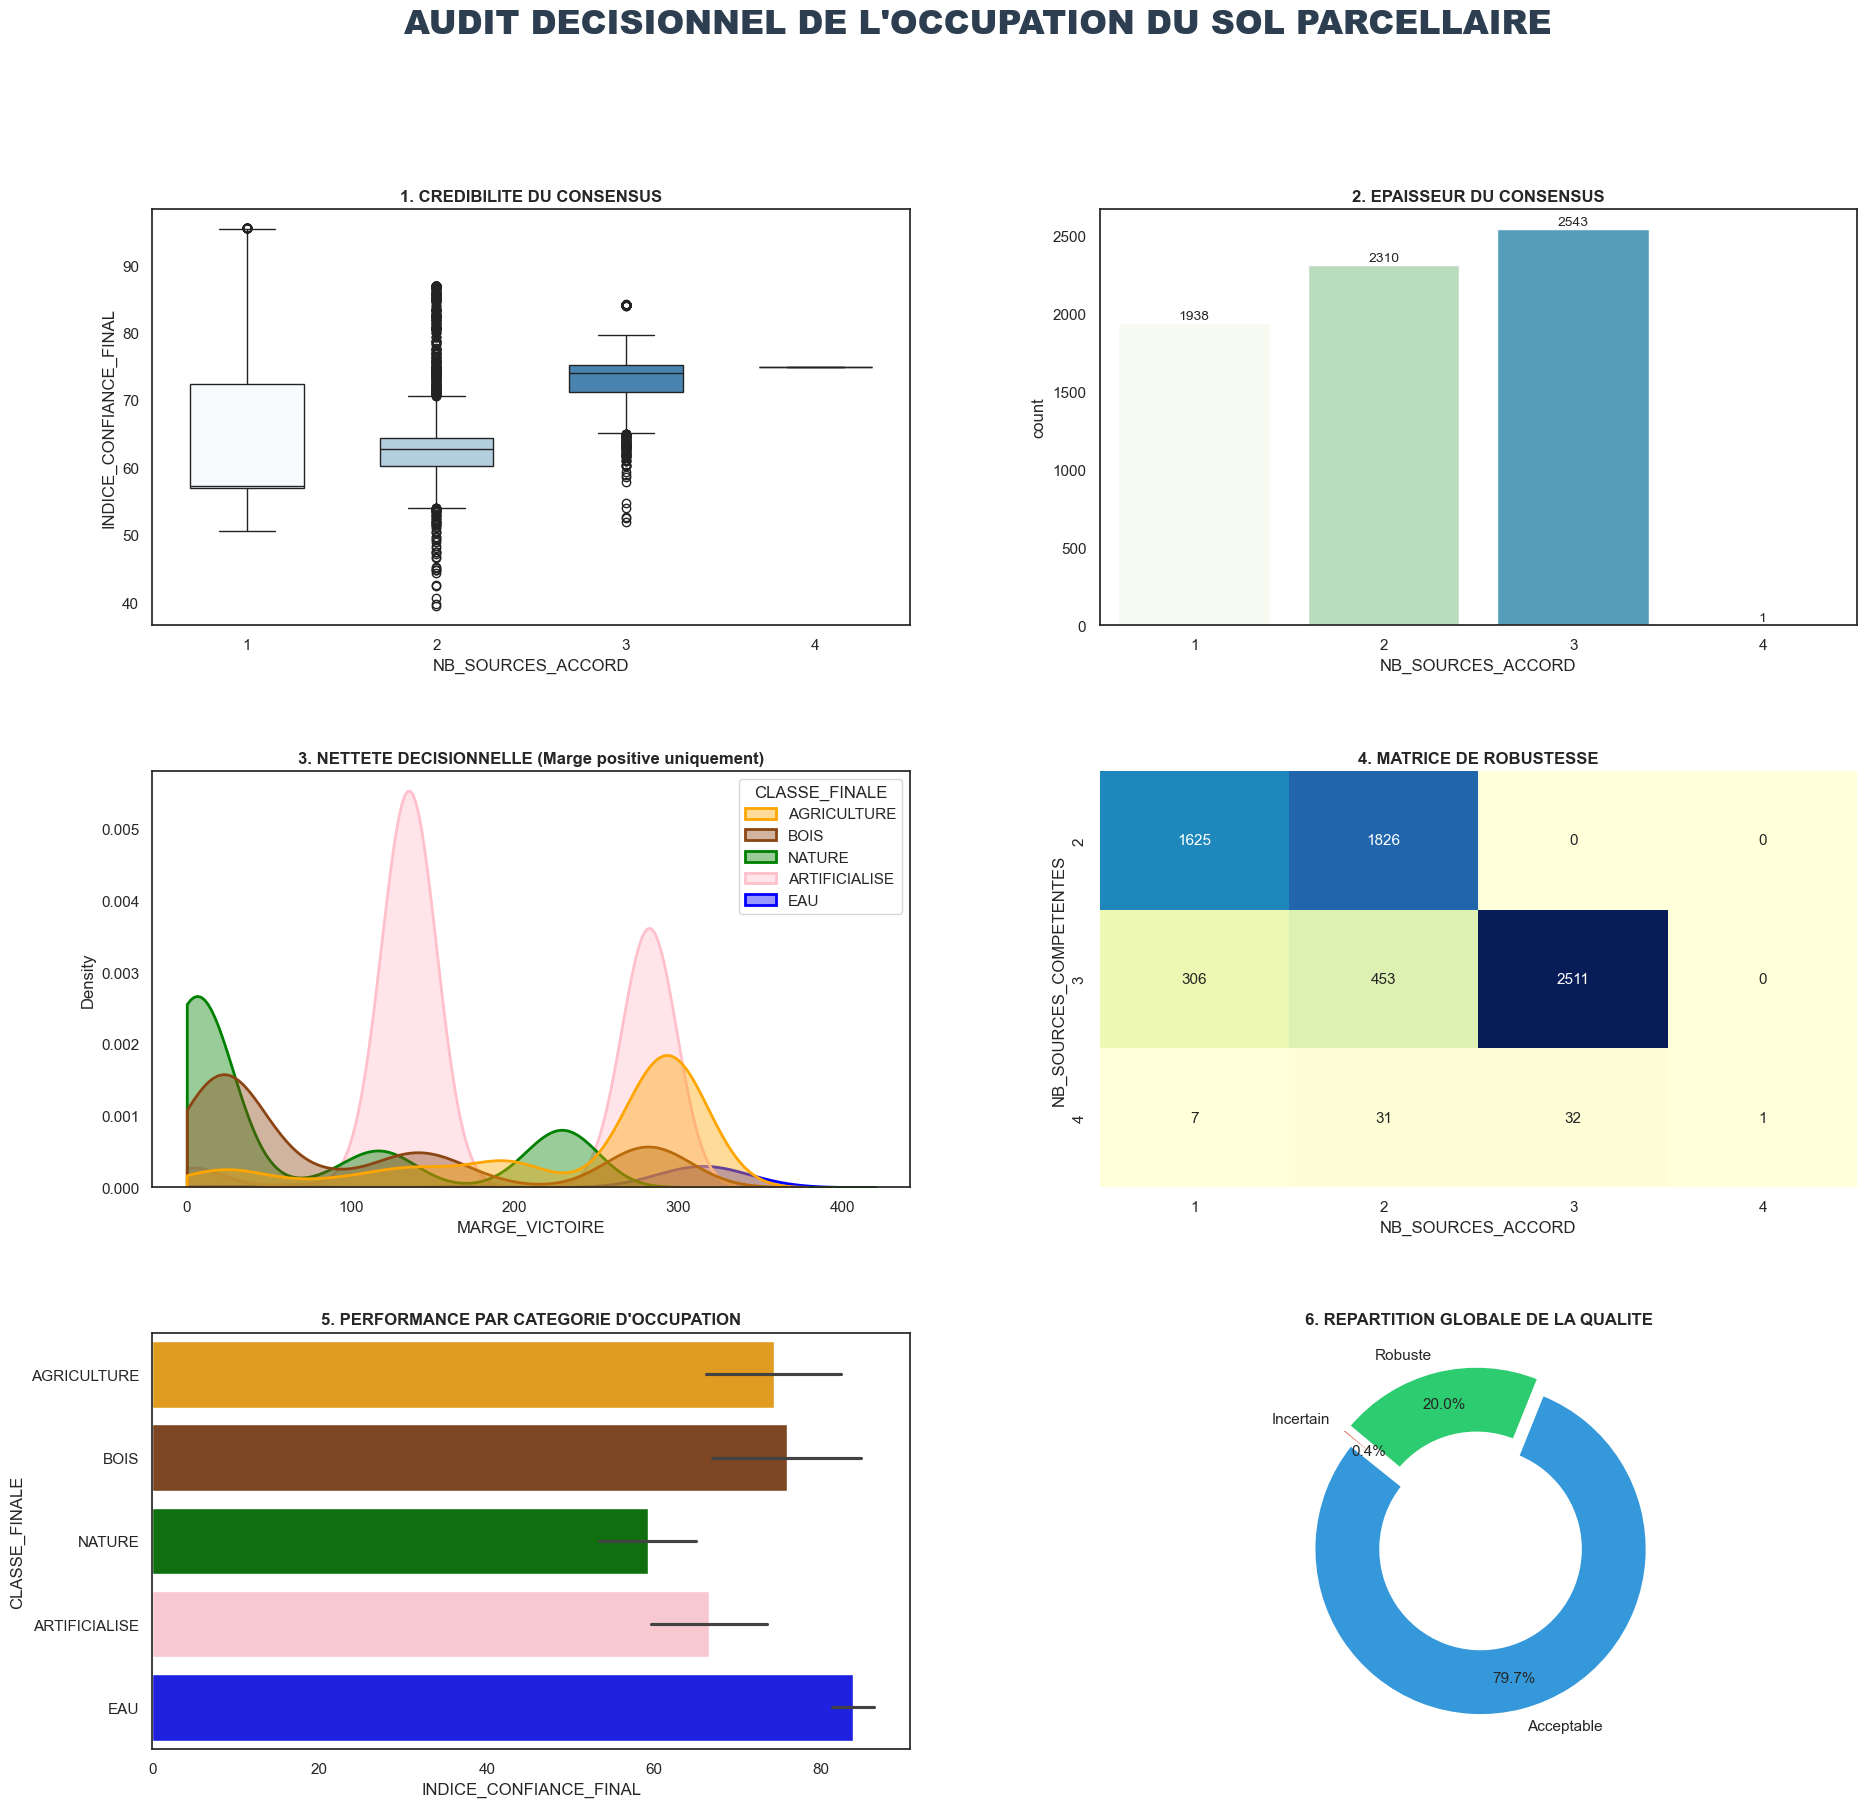

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

# =============================================================================
# DASHBOARD DE PERFORMANCE : VERSION CORRIGEE (COULEURS ET BORNES)
# =============================================================================

# Dictionnaire de couleurs officiel
COLOR_MAPPING = {
    'ARTIFICIALISE': '#ffc0cb',
    'AGRICULTURE': '#ffa500',
    'BOIS': '#8b4513',
    'NATURE': '#008000',
    'EAU': '#0000ff'
}

sns.set_theme(style="white")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titleweight': 'bold'
})

fig = plt.figure(figsize=(22, 20))
gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.25)

# --- 1. FIABILITE ET CONSENSUS ---
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df_synthese_globale, x='NB_SOURCES_ACCORD', y='INDICE_CONFIANCE_FINAL', 
            hue='NB_SOURCES_ACCORD', palette="Blues", ax=ax1, legend=False, width=0.6)
ax1.set_title("1. CREDIBILITE DU CONSENSUS")

# --- 2. EPAISSEUR DU CONSENSUS ---
ax2 = fig.add_subplot(gs[0, 1])
sns.countplot(data=df_synthese_globale, x='NB_SOURCES_ACCORD', palette="GnBu", ax=ax2, hue='NB_SOURCES_ACCORD', legend=False)
ax2.set_title("2. EPAISSEUR DU CONSENSUS")
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, xytext=(0, 5), textcoords='offset points')

# --- 3. NETTETE DECISIONNELLE (COULEURS CORRIGEES ET CLIP) ---
# Le parametre clip=(0, None) empeche la courbe de descendre dans le negatif
ax3 = fig.add_subplot(gs[1, 0])
sns.kdeplot(data=df_synthese_globale, x='MARGE_VICTOIRE', hue='CLASSE_FINALE', 
            fill=True, palette=COLOR_MAPPING, alpha=0.4, linewidth=2, ax=ax3, clip=(0, None))
ax3.set_title("3. NETTETE DECISIONNELLE (Marge positive uniquement)")

# --- 4. MATRICE DE ROBUSTESSE ---
ax4 = fig.add_subplot(gs[1, 1])
heatmap_data = df_synthese_globale.pivot_table(index='NB_SOURCES_COMPETENTES', 
                                               columns='NB_SOURCES_ACCORD', 
                                               aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlGnBu", cbar=False, ax=ax4)
ax4.set_title("4. MATRICE DE ROBUSTESSE")

# --- 5. PERFORMANCE PAR CATEGORIE (COULEURS CORRIGEES) ---
ax5 = fig.add_subplot(gs[2, 0])
sns.barplot(data=df_synthese_globale, x='INDICE_CONFIANCE_FINAL', y='CLASSE_FINALE', 
            hue='CLASSE_FINALE', palette=COLOR_MAPPING, errorbar="sd", ax=ax5, legend=False)
ax5.set_title("5. PERFORMANCE PAR CATEGORIE D'OCCUPATION")

# --- 6. REPARTITION GLOBALE DE LA QUALITE ---
ax6 = fig.add_subplot(gs[2, 1])
val_confiance = df_synthese_globale['INDICE_CONFIANCE_FINAL']
if val_confiance.max() <= 1.0: val_confiance = val_confiance * 100

bins = [0, 50, 75, 100.1]
labels = ['Incertain', 'Acceptable', 'Robuste']
zones_qual = pd.cut(val_confiance, bins=bins, labels=labels, include_lowest=True)
counts = zones_qual.value_counts().reindex(labels).fillna(0)

ax6.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=["#E74C3C", "#3498DB", "#2ECC71"],
        pctdistance=0.80, explode=[0.05, 0.05, 0.05], wedgeprops=dict(width=0.4, edgecolor='w', linewidth=2))
ax6.set_title("6. REPARTITION GLOBALE DE LA QUALITE")

plt.suptitle("AUDIT DECISIONNEL DE L'OCCUPATION DU SOL PARCELLAIRE", 
             fontsize=24, fontweight='black', y=0.98, color='#2C3E50')

plt.savefig(DIR_SORTIE_ROOT / "DASHBOARD_ARBITRAGE_FINAL.png", dpi=300, bbox_inches='tight')
plt.show()

# Module de spatialisation : Atlas d'arbitrage OCS

## 1. Fonctionnalités et rôle
Le module réalise la jointure entre le référentiel cadastral et les scores d'arbitrage. Son rôle est de fournir une preuve visuelle de la fiabilité des données via une production automatisée de planches de diagnostic.

## 2. Indicateurs cartographiés
Chaque dalle géographique est déclinée en trois volets analytiques :

* **Robustesse du consensus** : Visualisation du nombre de sources en accord thématique.
* **Fiabilité de la décision** : Représentation de l'indice de confiance final (0 à 100%).
* **Occupation du sol arbitrée** : Résultat final de la classification utilisant la charte graphique officielle.

In [42]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pathlib import Path
import os

# =============================================================================
# 1. CONFIGURATION DES PARAMETRES ET REPERTOIRES
# =============================================================================

DIR_SORTIE_ROOT = Path(r'C:/Users/liege/Desktop/GEOLAB/SORTIE')
OUTPUT_DIR_CARTES = Path(r'C:/Users/liege/Desktop/GEOLAB/SORTIE_CARTES_ARBITRAGE')

if not OUTPUT_DIR_CARTES.exists():
    os.makedirs(OUTPUT_DIR_CARTES)

CHAMPS_ID_SOCLE = ["CODE_DEP", "NOM_COM", "CODE_COM", "SECTION", "NUMERO", "DALLE"]

# Cartographie des couleurs (identique au referentiel precedent)
COLOR_MAPPING = {
    'ARTIFICIALISE': '#ffc0cb',
    'AGRICULTURE': '#ffa500',
    'BOIS': '#8b4513',
    'NATURE': '#008000',
    'EAU': '#0000ff',
    'AUTRE': '#ffffff'
}
CLASSES_LIST = ["ARTIFICIALISE", "AGRICULTURE", "NATURE", "BOIS", "EAU"]
CUSTOM_CMAP = ListedColormap([COLOR_MAPPING[cat] for cat in CLASSES_LIST])

# =============================================================================
# 2. CHARGEMENT DES DONNEES ET JOINTURE GEOGRAPHIQUE
# =============================================================================

# Chargement des couches vectorielles
gdf_zones = gpd.read_file("C:/Users/liege/Desktop/GEOLAB/ENTRER/ZONE.gpkg")
gdf_cad = gpd.read_file("C:/Users/liege/Desktop/GEOLAB/ENTRER/CADASTRE.gpkg")

# Preparation de la cle de jointure parcellaire
gdf_cad['PL_KEY'] = (gdf_cad['CODE_DEP'].astype(str) + 
                     gdf_cad['CODE_COM'].astype(str).str.zfill(3) + 
                     gdf_cad['SECTION'].astype(str).str.zfill(2) + 
                     gdf_cad['NUMERO'].astype(str).str.zfill(4))

# Jointure entre le cadastre et les resultats de l'arbitrage (df_final)
gdf_complet = gdf_cad.merge(df_final, left_on='PL_KEY', right_on='PL', how='inner')
gdf_complet['CLASSE_FINALE'] = pd.Categorical(gdf_complet['CLASSE_FINALE'], categories=CLASSES_LIST)

# =============================================================================
# 3. FONCTIONS DE MISE EN PAGE CARTOGRAPHIQUE
# =============================================================================

def apply_layout(ax, title, geom_dalle, parcelles_bounds):
    minx, miny, maxx, maxy = parcelles_bounds
    margin_side, margin_bottom = 0.07, 0.22 
    
    ax.set_xlim(minx - (maxx-minx)*margin_side, maxx + (maxx-minx)*margin_side)
    ax.set_ylim(miny - (maxy-miny)*margin_bottom, maxy + (maxy-miny)*margin_side)
    
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')

    # Indicateur du Nord
    ax.annotate('', xy=(0.05, 0.92), xytext=(0.05, 0.85), xycoords='axes fraction',
                arrowprops=dict(facecolor='black', width=1, headwidth=6))
    ax.text(0.05, 0.95, 'N', transform=ax.transAxes, fontsize=10, fontweight='bold', ha='center')
    
    # Barre d'echelle
    scalebar = AnchoredSizeBar(ax.transData, 500, '500 m', loc='lower right', pad=1.5, 
                               color='black', frameon=False, size_vertical=2, fontproperties={'size': 8})
    ax.add_artist(scalebar)
    
    # Emprise de la dalle
    gpd.GeoSeries([geom_dalle]).boundary.plot(ax=ax, color='red', linewidth=1.2, linestyle='--', zorder=10)
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)

# =============================================================================
# 4. GENERATION AUTOMATISEE DES DALLES DE DIAGNOSTIC
# =============================================================================

for idx, zone in gdf_zones.sort_values('DALLE').iterrows():
    nom_dalle = zone['DALLE']
    geom_dalle = zone['geometry']
    parcelles_dalle = gdf_complet[gdf_complet.intersects(geom_dalle)].copy()
    
    if parcelles_dalle.empty:
        continue
        
    bounds = parcelles_dalle.total_bounds 

    fig, axes = plt.subplots(1, 3, figsize=(26, 10), facecolor='white')
    fig.suptitle(f"DIAGNOSTIC D'ARBITRAGE FINAL : DALLE {nom_dalle}", fontsize=18, fontweight='black', y=0.92)

    # Carte 1 : Robustesse du consensus (Nombre de sources d'accord)
    ax = axes[0]
    ax_ins1 = inset_axes(ax, width="45%", height="3%", loc='lower left', borderpad=1.8)
    parcelles_dalle.plot(column='NB_SOURCES_ACCORD', ax=ax, cmap='YlGn', 
                         legend=True, cax=ax_ins1, legend_kwds={'orientation': "horizontal"})
    ax_ins1.set_title("Nombre de sources en accord", fontsize=8, pad=3)
    apply_layout(ax, "ROBUSTESSE DU CONSENSUS", geom_dalle, bounds)

    # Carte 2 : Fiabilite de la decision (Indice de confiance final)
    ax = axes[1]
    ax_ins2 = inset_axes(ax, width="45%", height="3%", loc='lower left', borderpad=1.8)
    parcelles_dalle.plot(column='INDICE_CONFIANCE_FINAL', ax=ax, cmap='Blues', 
                         legend=True, cax=ax_ins2, legend_kwds={'orientation': "horizontal"})
    ax_ins2.set_title("Indice de confiance", fontsize=8, pad=3)
    apply_layout(ax, "FIABILITE DE LA DECISION", geom_dalle, bounds)

    # Carte 3 : Resultat de l'arbitrage (Classes finales)
    ax = axes[2]
    parcelles_dalle.plot(column='CLASSE_FINALE', ax=ax, cmap=CUSTOM_CMAP, categorical=True, edgecolor='black', linewidth=0.1)
    
    # Legendes personnalisees
    patches = [plt.Rectangle((0,0),1,1, color=COLOR_MAPPING[cat]) for cat in CLASSES_LIST]
    ax.legend(patches, CLASSES_LIST, loc='lower left', ncol=3, fontsize=7.5, frameon=True, borderaxespad=1.0)
    apply_layout(ax, "OCCUPATION DU SOL ARBITREE", geom_dalle, bounds)

    # Finalisation et export
    plt.subplots_adjust(wspace=0.12, top=0.85)
    output_path = OUTPUT_DIR_CARTES / f"ARBITRAGE_DALLE_{nom_dalle}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

print(f"PROCESSUS TERMINE. CARTES DISPONIBLES DANS : {OUTPUT_DIR_CARTES}")

PROCESSUS TERMINE. CARTES DISPONIBLES DANS : C:\Users\liege\Desktop\GEOLAB\SORTIE_CARTES_ARBITRAGE


# Module d'exportation : Référentiel géographique final

## 1. Objectifs de l'Export
* **Spatialisation** : Associer les décisions d'occupation du sol aux géométries parcellaires réelles.
* **Interopérabilité** : Permettre l'exploitation immédiate des résultats sous les logiciels SIG (QGIS, ArcGIS).
* **Conservation des métadonnées** : Intégration de l'intégralité des attributs (Indice de confiance, Marge de victoire, Nombre de sources).

## 2. Spécifications du Fichier de Sortie
| Paramètre | Spécification |
| :--- | :--- |
| **Format** | OGC GeoPackage (.gpkg) |
| **Nom de la couche** | `OCS_PARCELLAIRE_FINALE` |
| **Géométrie** | Polygones (Cadastre source) |
| **Projection** | Lambert-93 (EPSG:2154) |

## 3. Structure des Attributs
Le fichier final contient toutes les variables clés de l'étude pour chaque parcelle :
1. **CLASSE_FINALE** : Catégorie d'occupation du sol arbitrée.
2. **INDICE_CONFIANCE_FINAL** : Score de fiabilité de la décision.
3. **NB_SOURCES_ACCORD** : Force du consensus multi-sources.
4. **SCORES_[CLASSE]** : Détail des points obtenus par chaque catégorie.

---

In [37]:
import geopandas as gpd
from pathlib import Path

# =============================================================================
# EXPORT FINAL NETTOYÉ : GÉNÉRATION DU GEOPACKAGE (GPKG)
# =============================================================================

FILE_OUTPUT_GPKG = DIR_SORTIE_ROOT / "REFERENTIEL_OCS_ARBITRE.gpkg"

# 1. Préparation du cadastre
gdf_cad = gpd.read_file("C:/Users/liege/Desktop/GEOLAB/ENTRER/CADASTRE.gpkg")
gdf_cad['PL_KEY'] = (gdf_cad['CODE_DEP'].astype(str) + 
                     gdf_cad['CODE_COM'].astype(str).str.zfill(3) + 
                     gdf_cad['SECTION'].astype(str).str.zfill(2) + 
                     gdf_cad['NUMERO'].astype(str).str.zfill(4))

# 2. Identification et suppression des colonnes doublons dans df_final
# On ne garde de df_final que 'PL' et les colonnes de résultats (Scores, Classe, Confiance)
cols_communes = [c for c in gdf_cad.columns if c in df_final.columns and c != 'PL']
df_final_clean = df_final.drop(columns=cols_communes)

# 3. Jointure propre
gdf_final_spatial = gdf_cad.merge(df_final_clean, left_on='PL_KEY', right_on='PL', how='inner')

# 4. Nettoyage final des clés techniques
gdf_final_spatial = gdf_final_spatial.drop(columns=['PL_KEY', 'PL'])

# 5. Export GPKG
gdf_final_spatial.to_file(FILE_OUTPUT_GPKG, layer='OCS_PARCELLAIRE_FINALE', driver="GPKG")

print(f"EXPORT NETTOYÉ TERMINÉ : {FILE_OUTPUT_GPKG}")

EXPORT NETTOYÉ TERMINÉ : C:\Users\liege\Desktop\GEOLAB\SORTIE\REFERENTIEL_OCS_ARBITRE.gpkg


# AUDIT DE SENSIBILITÉ : ÉVALUATION DE L'INFLUENCE DES SOURCES 

Ce module assure l'audit de robustesse du moteur d'arbitrage de l'Occupation du Sol (OCS). La méthodologie repose sur l'exclusion itérative de chaque source de données afin de mesurer l'instabilité thématique et la dégradation des indicateurs de performance induites par l'absence d'un flux spécifique.

## 1. PROTOCOLE EXPÉRIMENTAL
Le processus est automatisé selon les étapes suivantes :
1.  **Exclusion** : Retrait systématique d'une source unique du pool décisionnel.
2.  **Simulation** : Recalcul complet du processus décisionnel (scores pondérés, classe élue, marge et confiance).
3.  **Comparaison** : Confrontation spatiale et statistique entre le scénario dégradé et le référentiel de référence (intégrant la totalité des sources).
4.  **Métrologie** : Extraction des deltas de performance par classe d'occupation du sol et par source exclue.

## 2. INDICATEURS DE PERFORMANCE ANALYSÉS

### A. Transferts nets (Unités parcellaires)
Cet indicateur quantifie la redistribution des parcelles entre les classes. Il permet d'identifier les classes "refuges" : si l'absence d'une source experte augmente mécaniquement le volume d'une classe secondaire, cela démontre une fonction de **verrou thématique** assurée par la source exclue.

### B. Matrice de mutation (Instabilité physique)
La matrice dénombre les changements effectifs de catégories. Une valeur élevée indique une dépendance thématique critique de la classe concernée vis-à-vis de la source exclue (ex: dépendance de la classe BOIS vis-à-vis de la BD FORÊT).

### C. Variation de la marge de victoire (Netteté)
La marge de victoire mesure l'écart entre la classe dominante et sa dauphine. Une réduction de cette marge suite à l'exclusion d'une source indique une perte de **netteté décisionnelle** et une hausse de l'ambiguïté statistique lors de l'arbitrage.

### D. Impact sur l'indice de confiance (Qualité)
Cet indicateur mesure l'érosion de la certitude. Une source peut ne pas modifier la classe finale mais être essentielle pour garantir un **Indice de Confiance (IC)** élevé. Son retrait affaiblit la force probante du signal sans nécessairement changer l'élu thématique.

## 3. SYNTHÈSE DES IMPACTS CRITIQUES
La hiérarchie finale classe les sources selon leur "pouvoir de bascule" (nombre total de re-classifications provoquées par leur retrait).

## 4. ANALYSE DU PARADOXE DE LA CONFIANCE
L'audit souligne une observation métrologique majeure : l'exclusion d'une source de contradiction potentielle (telle qu'OSO) peut provoquer une hausse artificielle de l'Indice de Confiance. Ce phénomène traduit une perte de **sens critique** du modèle (unanimité obtenue par réduction du nombre de témoins) et non une amélioration de la précision réelle. Le maintien de la redondance multi-sources est donc indispensable pour garantir la robustesse du référentiel face aux spécificités du terrain.

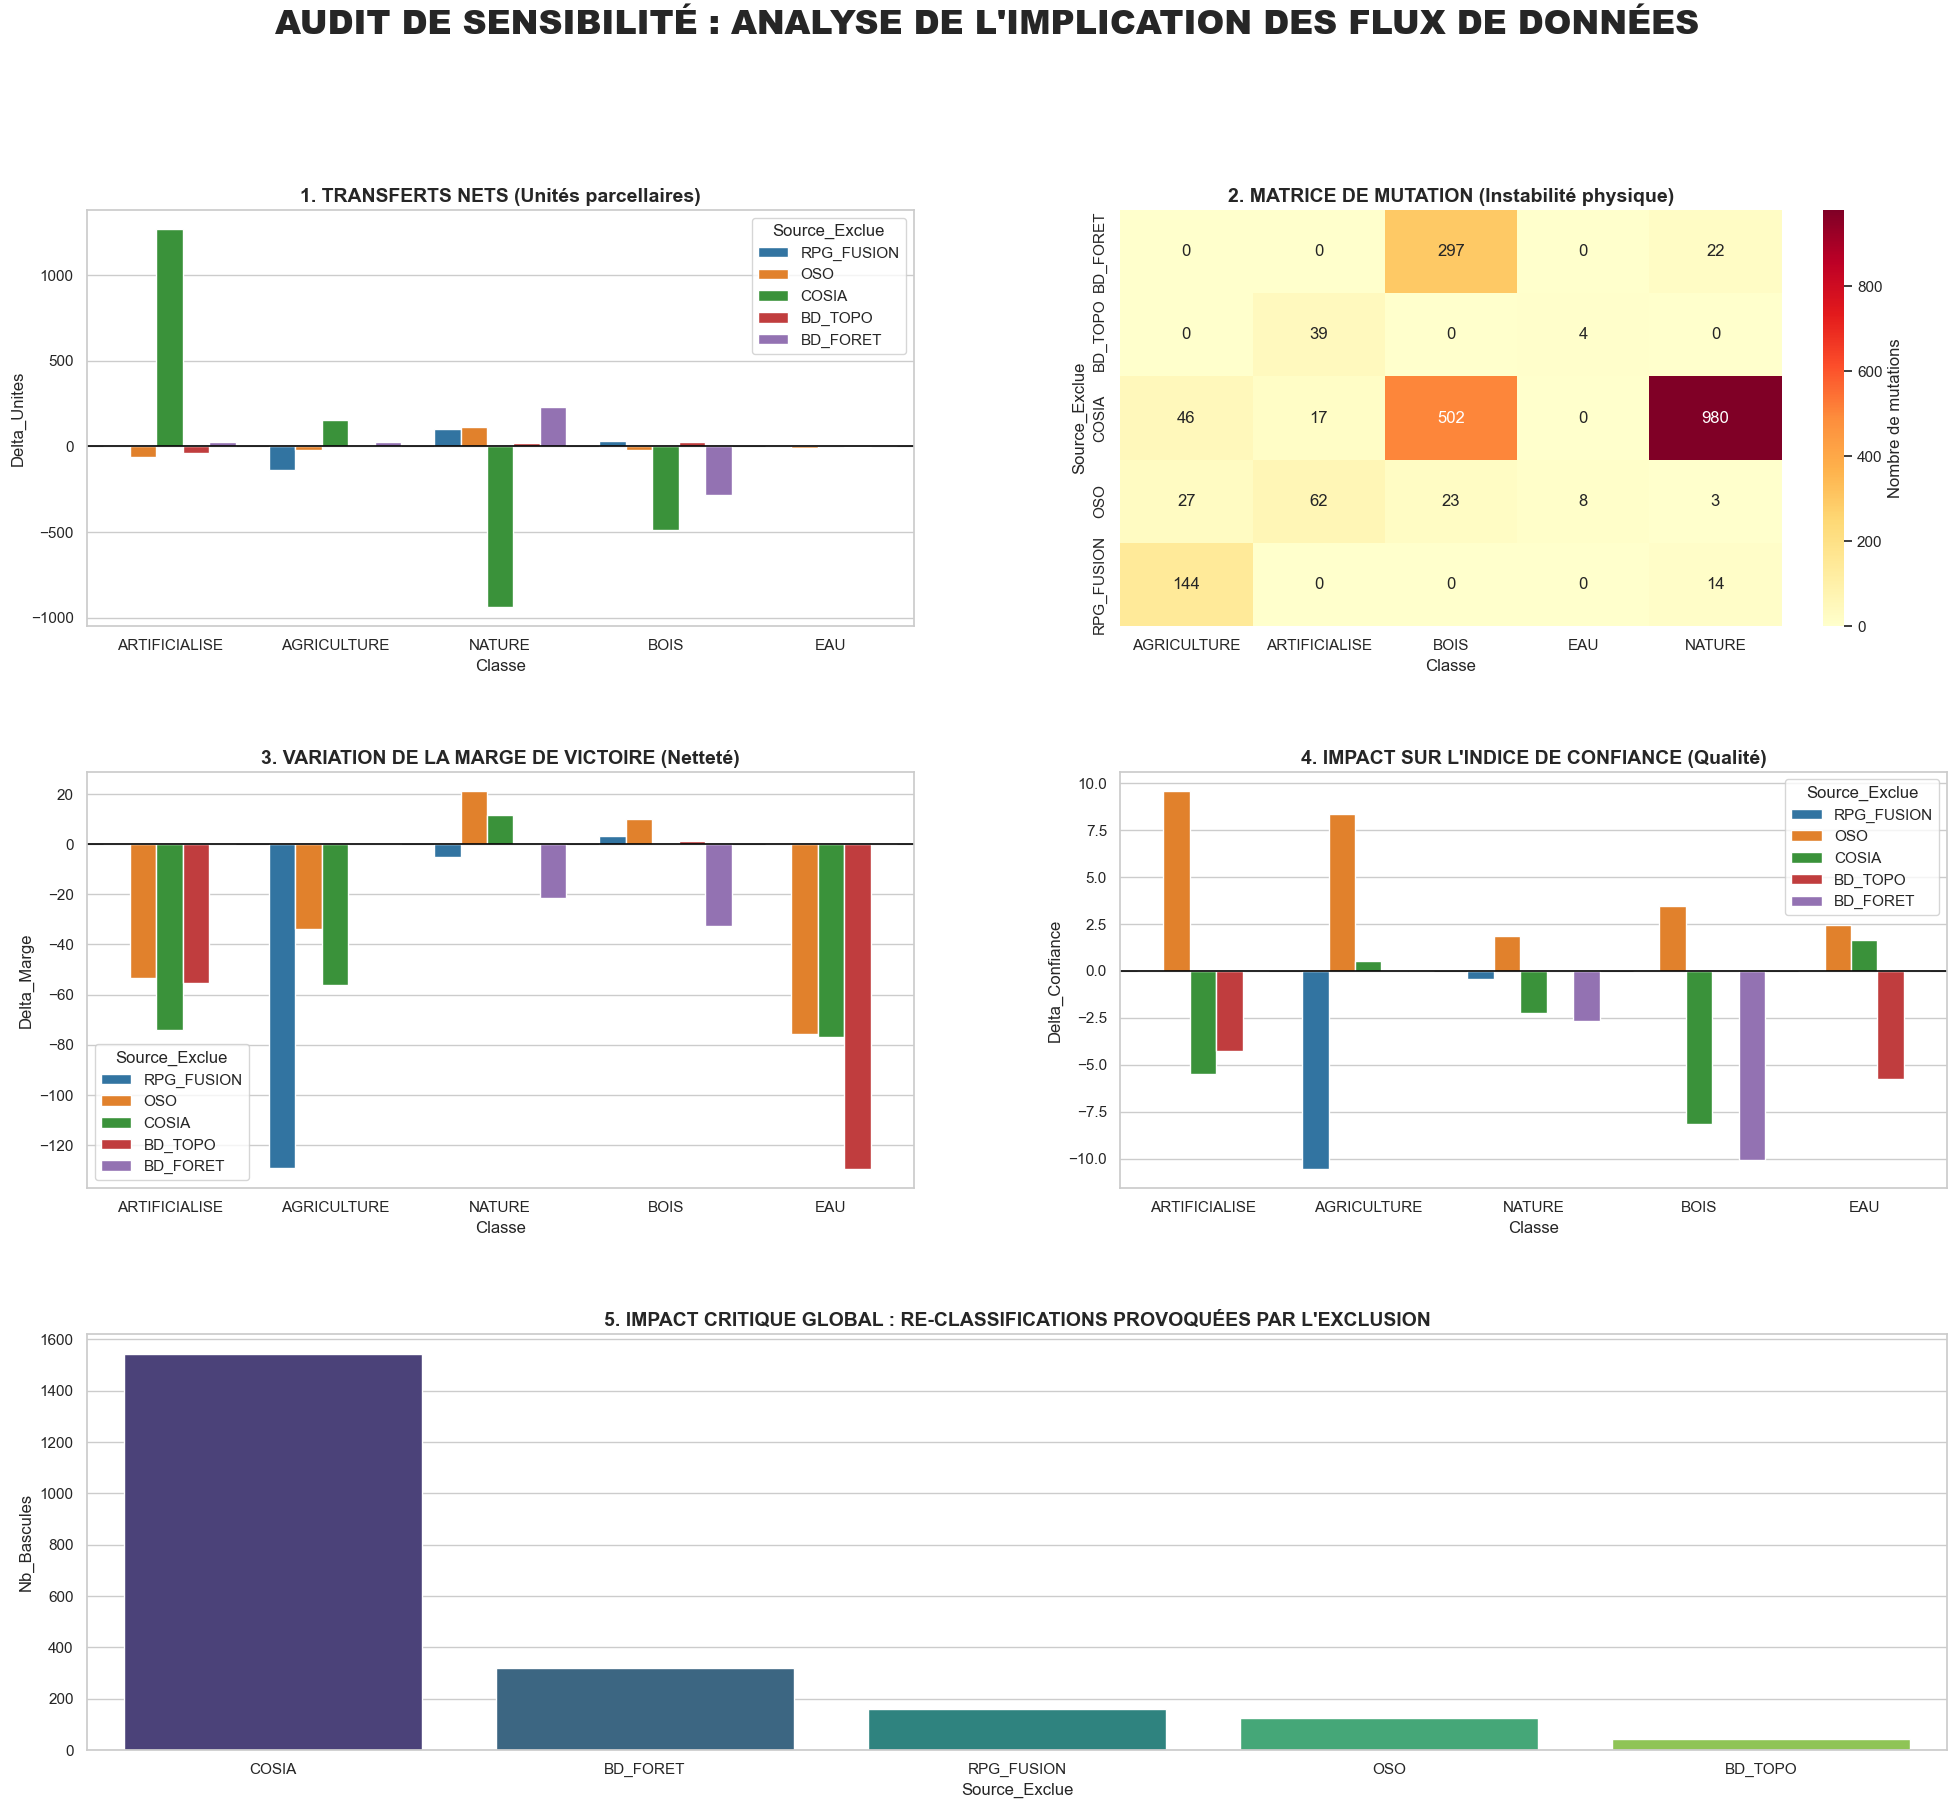

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# =============================================================================
# 1. LOGIQUE D'AUDIT : SIMULATION D'ARBITRAGE PAR EXCLUSION (LEAVE-ONE-OUT)
# =============================================================================

def simuler_arbitrage(df_base, sources_actives):
    """
    Recalcule l'intégralité du processus décisionnel en limitant les entrées
    aux sources définies dans 'sources_actives'.
    """
    df_simul = df_base.copy()
    
    # Réinitialisation et calcul des scores pondérés par thématique
    for cl in classes_finales:
        score_col = f"SCORE_{cl}"
        df_simul[score_col] = 0.0
        for src in sources_actives:
            if f"{src}_DOM" in df_simul.columns:
                # Application du facteur de stabilité et des bonus experts
                f_stab = 1 + (df_simul[f"{src}_STAB"].fillna(0) / 1000)
                pts = (df_simul[f"{src}_FIAB_DOM"] * df_simul[f"{src}_COEFF_SOURCE"] * f_stab)
                bonus = domaines_experts.get(src, {}).get(cl, 1.0)
                mask = (df_simul[f"{src}_DOM"] == cl)
                df_simul.loc[mask, score_col] += (pts[mask] * bonus)
    
    # Identification de la classe dominante (idxmax)
    df_simul['CL_TEST'] = df_simul[colonnes_scores].idxmax(axis=1).str.replace('SCORE_', '')
    
    # Mesure de la netteté décisionnelle (Marge de Victoire)
    all_scores = df_simul[colonnes_scores].values
    all_scores.sort(axis=1)
    df_simul['MARGE_TEST'] = np.round(all_scores[:, -1] - all_scores[:, -2], 2)
    
    # Évaluation de la robustesse (Indice de Confiance recalculé)
    def calc_conf(row):
        elu = row['CL_TEST']
        accords = [row[f"{s}_FIAB_DOM"] * row[f"{s}_COEFF_SOURCE"] 
                   for s in sources_actives if row.get(f"{s}_DOM") == elu]
        return round(np.mean(accords), 2) if accords else 0.0

    df_simul['CONF_TEST'] = df_simul.apply(calc_conf, axis=1)
    
    return df_simul[['PL', 'CL_TEST', 'CONF_TEST', 'MARGE_TEST']]

# =============================================================================
# 2. TRAITEMENT STATISTIQUE ET GÉNÉRATION DU DASHBOARD
# =============================================================================

# Paramétrage esthétique global
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.sans-serif': 'Arial', 'axes.titleweight': 'bold'})

fig = plt.figure(figsize=(24, 20))
gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.25)
donnees_audit = []

# Itération sur chaque source pour mesurer son influence individuelle
for src in sources_noms:
    actives = [s for s in sources_noms if s != src]
    df_test = simuler_arbitrage(df_synthese_globale, actives)
    
    # Consolidation avec le référentiel de référence
    comp = pd.merge(df_final[['PL', 'CLASSE_FINALE', 'INDICE_CONFIANCE_FINAL', 'MARGE_VICTOIRE']], 
                    df_test, on='PL', how='inner')
    
    for cl in classes_finales:
        mask_cl = (comp['CLASSE_FINALE'] == cl)
        if mask_cl.sum() == 0: continue
        
        # Calcul des indicateurs de dérive thématique et statistique
        delta_unites = (comp['CL_TEST'] == cl).sum() - mask_cl.sum()
        delta_conf = comp.loc[mask_cl, 'CONF_TEST'].mean() - comp.loc[mask_cl, 'INDICE_CONFIANCE_FINAL'].mean()
        delta_marge = comp.loc[mask_cl, 'MARGE_TEST'].mean() - comp.loc[mask_cl, 'MARGE_VICTOIRE'].mean()
        nb_bascules = (comp.loc[mask_cl, 'CL_TEST'] != cl).sum()
        
        donnees_audit.append({
            'Source_Exclue': src, 'Classe': cl,
            'Delta_Unites': delta_unites, 'Delta_Confiance': delta_conf,
            'Delta_Marge': delta_marge, 'Nb_Bascules': nb_bascules
        })

df_audit = pd.DataFrame(donnees_audit)

# --- VISUALISATION DES RÉSULTATS ---

# 1. Bilan des flux parcellaires (Transferts nets)
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=df_audit, x='Classe', y='Delta_Unites', hue='Source_Exclue', ax=ax1, palette="tab10")
ax1.axhline(0, color='black', lw=1.2)
ax1.set_title("1. TRANSFERTS NETS (Unités parcellaires)", fontsize=14)

# 2. Matrice de mutation (Dépendance thématique)
ax2 = fig.add_subplot(gs[0, 1])
pivot_bascules = df_audit.pivot(index='Source_Exclue', columns='Classe', values='Nb_Bascules')
sns.heatmap(pivot_bascules, annot=True, fmt='g', cmap="YlOrRd", ax=ax2, cbar_kws={'label': 'Nombre de mutations'})
ax2.set_title("2. MATRICE DE MUTATION (Instabilité physique)", fontsize=14)

# 3. Érosion de la discrimination (Marge)
ax3 = fig.add_subplot(gs[1, 0])
sns.barplot(data=df_audit, x='Classe', y='Delta_Marge', hue='Source_Exclue', ax=ax3, palette="tab10")
ax3.axhline(0, color='black', lw=1.2)
ax3.set_title("3. VARIATION DE LA MARGE DE VICTOIRE (Netteté)", fontsize=14)

# 4. Dégradation de la robustesse (Confiance)
ax4 = fig.add_subplot(gs[1, 1])
sns.barplot(data=df_audit, x='Classe', y='Delta_Confiance', hue='Source_Exclue', ax=ax4, palette="tab10")
ax4.axhline(0, color='black', lw=1.2)
ax4.set_title("4. IMPACT SUR L'INDICE DE CONFIANCE (Qualité)", fontsize=14)

# 5. Hiérarchie globale des sources (Impact critique)
ax5 = fig.add_subplot(gs[2, :])
impact_global = df_audit.groupby('Source_Exclue')['Nb_Bascules'].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=impact_global, x='Source_Exclue', y='Nb_Bascules', hue='Source_Exclue', palette="viridis", ax=ax5, legend=False)
ax5.set_title("5. IMPACT CRITIQUE GLOBAL : RE-CLASSIFICATIONS PROVOQUÉES PAR L'EXCLUSION", fontsize=14)

plt.suptitle("AUDIT DE SENSIBILITÉ : ANALYSE DE L'IMPLICATION DES FLUX DE DONNÉES", fontsize=24, fontweight='black', y=0.98)
plt.savefig(DIR_SORTIE_ROOT / "DASHBOARD_SENSIBILITE_OCS.png", dpi=300, bbox_inches='tight')
plt.show()